In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import folium
from folium import plugins
from folium.features import DivIcon

# 지도 시각화

In [249]:
merged_df = pd.read_csv("seoul_avg_price.csv")

In [259]:
merged_df.columns

Index(['거래년도', '지역명', '('거래일', 'min')', '('거래일', 'max')', '('건축년도', 'min')',
       '('건축년도', 'max')', '('건축년도', 'mean')', '('거래금액', 'min')',
       '('거래금액', 'max')', '('거래금액', 'mean')', '거래량', '구'],
      dtype='object')

### 구 컬럼 추가

In [251]:
merged_df['구'] = merged_df['지역명'].str.split().str[1]

### 서울 행정구 경계 데이터 불러오기

In [253]:
state_geo = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'
data = requests.get(state_geo)
jsonResult = json.loads(data.text)

### 구 중심 좌표 구하는 함수

In [255]:
def center_calc(points_df):
    x = points_df.x
    y = points_df.y

    X = (max(x)+min(x))/2.
    Y = (max(y)+min(y))/2.

    return X, Y

### json에서 구 경계 좌표 리스트로 변환

In [256]:
def points_array(points):

    final_points = []

    for x in range(0, len(points)):

        if len(points[x]) == 2:
            final_points.append(points[x])
        else:
            target = points[x]
            for y in range(0, len(target)):
                final_points.append(target[y])

    return final_points

### json 파일에서 구, X좌표, Y좌표를 받아오기 위한 함수

In [257]:
center_locations = pd.DataFrame()
names = []
x_list = []
y_list = []
for x in range(0, len(jsonResult['features'])):
    name = jsonResult['features'][x]['properties']['name']
    # 중앙값 생성
    points = jsonResult['features'][x]['geometry']['coordinates'][0]
    points = points_array(points)
    points_df = pd.DataFrame(points)
    points_df.columns = ['x','y']
    X, Y = center_calc(points_df)

    # 결과
    names.append(name)
    x_list.append(X)
    y_list.append(Y)

# 데이터 프레임 생성
center_locations['NAME'] = names
center_locations['X'] = x_list
center_locations['Y'] = y_list

### 

In [263]:
m = folium.Map(location=[37.566345, 126.977893], tiles="Cartodb Positron")

folium.Choropleth(
    geo_data=state_geo,
    data=merged_df,
    columns=['구', "('거래금액', 'mean')"],
    key_on='feature.properties.name',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.3,
    color = 'gray'
).add_to(m)


for idx in center_locations.index:
    folium.map.Marker(
        # 위경도 위치
        [center_locations.iloc[idx]['Y'], center_locations.iloc[idx]['X']],

        # DivIcon 을 사용
        # html 태그를 이용해서 text를 올릴 수 있음
        icon=DivIcon(
            # icon px 사이즈
            icon_size=(0, 0),
            # icon 좌 상단 위치 설정
            icon_anchor=(20, 0),

            # html 형식으로 text 추가
            # div 태그 안에 style 형식 추가
            html='<div\
                    style="\
                        font-size: 0.8rem;\
                        color: black;\
                        width:85px;\
                        text-align:left;\
                        margin:0px;\
                    "><b>'
            + center_locations.iloc[idx]['NAME']
            + '</b></div>',
        )).add_to(m)

m.save("map.html")
m

# 층, 면적 분석

In [5]:
df = pd.read_csv('seoul_apart4.csv')

In [20]:
df = df[df['거래일'] != 2023]

In [25]:
df.describe()

,거래일,평수,층,건축년도,거래금액,평당 가격
count,611925.000000,611925.000000,611925.000000,611925.000000,6.119250e+05,611925.000000
mean,2017.532524,23.591081,9.039338,1999.654497,6.633501e+04,2808.388190
std,2.018383,9.163101,6.106368,9.605252,5.139640e+04,1612.368418
min,2015.000000,3.100000,1.000000,1961.000000,7.000000e+02,27.240000
25%,2016.000000,18.100000,4.000000,1993.000000,3.600000e+04,1730.770000
50%,2017.000000,25.400000,8.000000,2000.000000,5.200000e+04,2331.540000
75%,2019.000000,25.700000,13.000000,2006.000000,7.950000e+04,3365.760000
max,2022.000000,128.400000,69.000000,2022.000000,1.450000e+06,22935.780000


In [12]:
plt.rc('font', family='Malgun Gothic')

# 1. 선호된 층
### 층을 '1-5','6-10', '11-15', '16-20', '21-25', '26-30', '31 이상' 으로 범주화

In [67]:
df['층 범주'] = pd.cut(df['층'], bins=[0, 5, 10, 15, 20, 25, 30, 100],
       labels=['1-5','6-10', '11-15', '16-20', '21-25', '26-30', '31 이상'],
       right=True)

<ipython-input-67-907a260949da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['층 범주'] = pd.cut(df['층'], bins=[0, 5, 10, 15, 20, 25, 30, 100],


### 층 범주별 거래량

<AxesSubplot:xlabel='층 범주', ylabel='Count'>

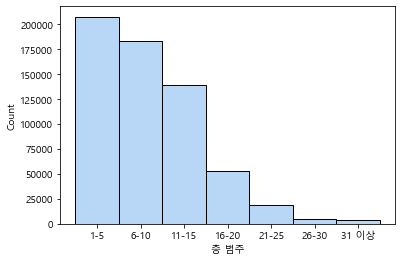

In [70]:
sns.histplot(data=df, x='층 범주')

### 층 범주별 평균 평당 가격

<AxesSubplot:xlabel='층 범주', ylabel='평당 가격'>

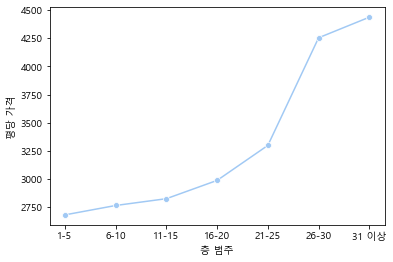

In [80]:
tmp = pd.DataFrame(df.groupby('층 범주')['평당 가격'].mean())
sns.lineplot(data=tmp, x='층 범주', y='평당 가격', marker='o')

### 층별 평당 가격

<AxesSubplot:xlabel='층', ylabel='평당 가격'>

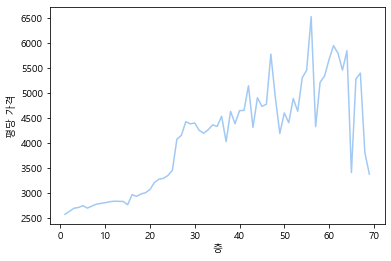

In [81]:
tmp2 = pd.DataFrame(df.groupby('층')['평당 가격'].mean())
sns.lineplot(data=tmp2, x='층', y='평당 가격')

In [88]:
tmp3 = pd.DataFrame(df.groupby(['거래일', '층 범주'])['평당 가격'].count())

In [114]:
tmp3.reset_index(inplace=True)

In [115]:
tmp3.columns

Index(['거래일', '층 범주', '평당 가격'], dtype='object')

### 연도별, 층 범주별 거래량

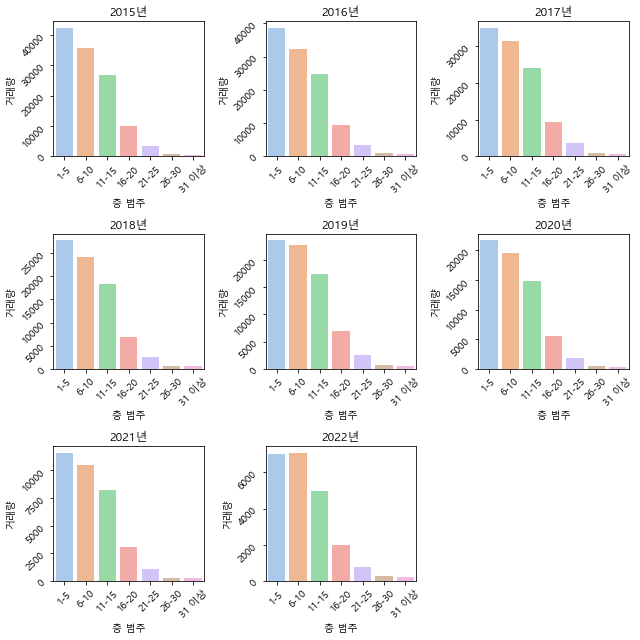

In [149]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

axes = axes.flatten()

for i, year in enumerate(range(2015, 2023)):
    ax = axes[i]
    
    x = ['1-5','6-10', '11-15', '16-20', '21-25', '26-30', '31 이상']
    y = tmp3[tmp3['거래일'] == year]['거래량']

    sns.barplot(x=x, y=y, ax=ax)

    ax.set_title(f'{year}년')
    ax.set_xlabel('층 범주')
    ax.set_ylabel('거래량')
    ax.tick_params(labelrotation=45)

# 빈 subplot 숨기기
for i in range(len(range(2015, 2023)), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='층 범주', ylabel='거래량'>

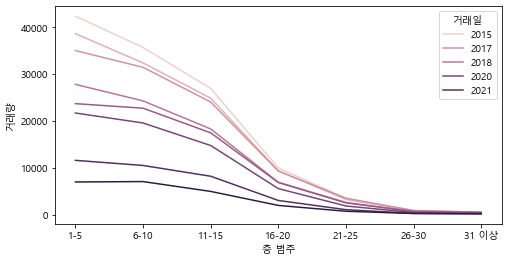

In [150]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=tmp3, x='층 범주', y='거래량', hue='거래일')

### 연도별 거래량 불균형 -> 퍼센트로 비교

In [143]:
df.groupby(['거래일', '층 범주'])['평당 가격'].count()

거래일   층 범주 
2015  1-5      42339
      6-10     35680
      11-15    26931
      16-20     9992
      21-25     3512
               ...  
2022  11-15     4991
      16-20     2005
      21-25      760
      26-30      275
      31 이상      203
Name: 평당 가격, Length: 56, dtype: int64

In [147]:
tmp3.rename(columns={'평당 가격': '거래량'}, inplace=True)

In [168]:
d = tmp3.groupby(['거래일'])['거래량'].sum()

In [169]:
tmp3['거래량_per'] = tmp3.apply(lambda row: row['거래량'] / d[row['거래일']], axis=1)

<AxesSubplot:xlabel='층 범주', ylabel='거래량_per'>

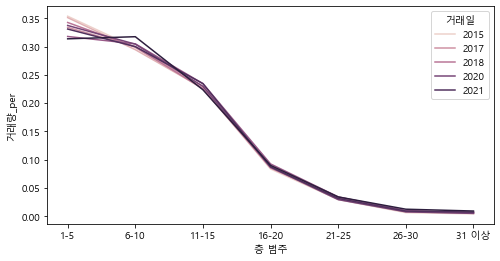

In [171]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=tmp3, x='층 범주', y='거래량_per', hue='거래일')

In [205]:
tmp3_1 = tmp3.loc[(tmp3['층 범주'] == '1-5') | (tmp3['층 범주'] == '6-10')]

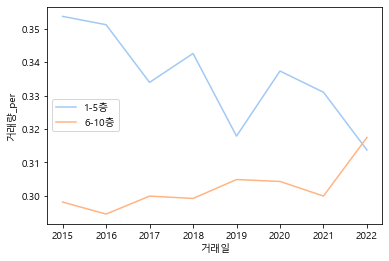

In [225]:
fig = sns.lineplot(x=tmp3_1['거래일'], y=tmp3_1['거래량_per'], hue=tmp3_1['층 범주'],legend=False)
plt.legend(loc='center left', labels=['1-5층', '6-10층'])
plt.show(fig)

In [215]:
tmp3_2 = tmp3_1.loc[(tmp3_1['거래일'] == 2015) | (tmp3_1['거래일'] == 2022)]

In [219]:
tmp3_2.sort_values('층 범주')

,거래일,층 범주,거래량,거래량_per
0,2015,1-5,42339,0.353736
49,2022,1-5,7003,0.313698
1,2015,6-10,35680,0.298101
50,2022,6-10,7087,0.317461


#### 낮은 층의 거래가 활발하다.
#### 큰 변화가 있지는 않다.
#### 굳이 변화를 찾자면 1-5평대 아파트의 거래량은 하락세, 6-10 평대 아파트의 아파트는 상승세이다. 


# 3. 선호된 면적

In [174]:
df['평 범주'] = pd.cut(df['평수'], bins=[0, 10, 20, 30, 40, 50, 60, 200],
       labels=['1-10','11-20', '21-30', '31-40', '41-50', '51-60', '61 이상'],
       right=True)

<ipython-input-174-cdba502af059>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['평 범주'] = pd.cut(df['평수'], bins=[0, 10, 20, 30, 40, 50, 60, 200],


### 평 범주별 거래량

<AxesSubplot:xlabel='평 범주', ylabel='Count'>

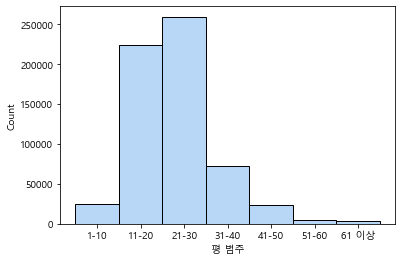

In [175]:
sns.histplot(data=df, x='평 범주')

### 평 범주별 평당 가격

<AxesSubplot:xlabel='평 범주', ylabel='평당 가격'>

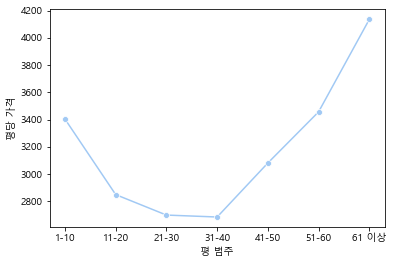

In [195]:
tmp5 = pd.DataFrame(df.groupby('평 범주')['평당 가격'].mean())
sns.lineplot(data=tmp5, x='평 범주', y='평당 가격', marker='o')

### 평 범주별 거래금액

<AxesSubplot:xlabel='평 범주', ylabel='거래금액'>

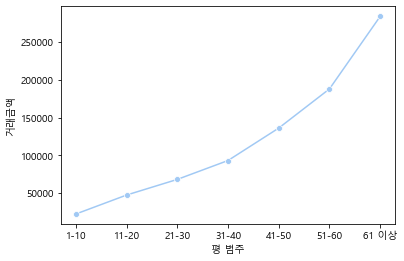

In [198]:
tmp5 = pd.DataFrame(df.groupby('평 범주')['거래금액'].mean())
sns.lineplot(data=tmp5, x='평 범주', y='거래금액', marker='o')

In [179]:
tmp6 = pd.DataFrame(df.groupby(['거래일', '평 범주'])['거래금액'].count())

In [182]:
tmp6.reset_index(inplace=True)

In [186]:
tmp6.rename(columns={'거래금액': '거래량'}, inplace=True)

### 연도별, 층 범주별 거래량

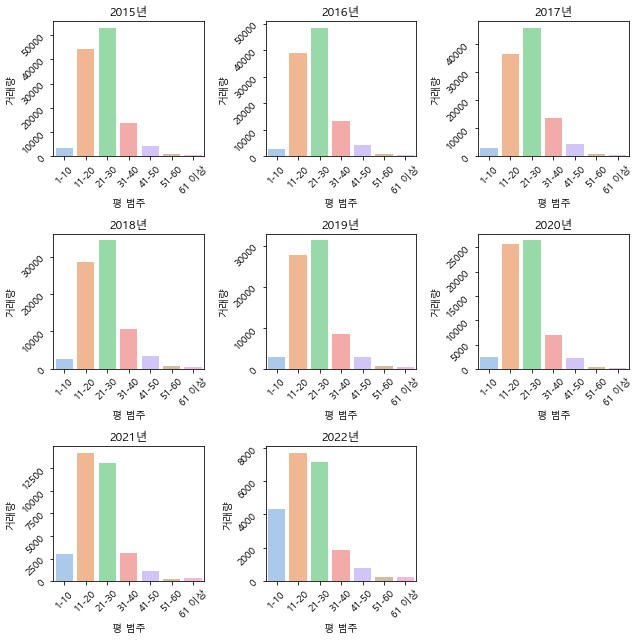

In [188]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

axes = axes.flatten()

for i, year in enumerate(range(2015, 2023)):
    ax = axes[i]
    
    x = ['1-10','11-20', '21-30', '31-40', '41-50', '51-60', '61 이상']
    y = tmp6[tmp6['거래일'] == year]['거래량']

    sns.barplot(x=x, y=y, ax=ax)

    ax.set_title(f'{year}년')
    ax.set_xlabel('평 범주')
    ax.set_ylabel('거래량')
    ax.tick_params(labelrotation=45)

# 빈 subplot 숨기기
for i in range(len(range(2015, 2023)), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='평 범주', ylabel='거래량'>

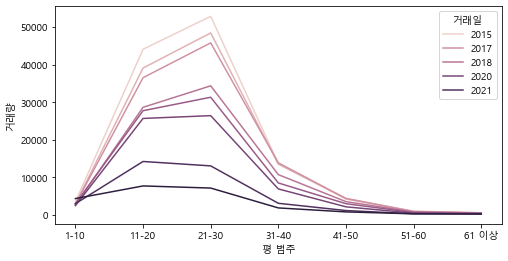

In [190]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=tmp6, x='평 범주', y='거래량', hue='거래일')

In [191]:
d2 = tmp6.groupby(['거래일'])['거래량'].sum()

In [192]:
tmp6['거래량_per'] = tmp6.apply(lambda row: row['거래량'] / d2[row['거래일']], axis=1)

<AxesSubplot:xlabel='평 범주', ylabel='거래량_per'>

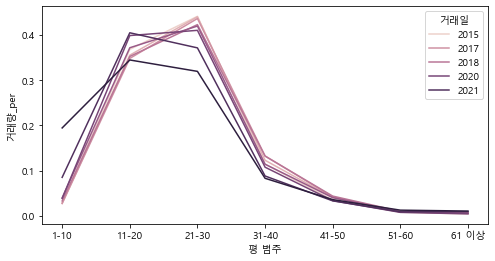

In [194]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=tmp6, x='평 범주', y='거래량_per', hue='거래일')

### 작은 평수(원투룸)의 거래량이 많이 늘어남
-> 가격도 연도별로 비교해보기. 수요가 늘어난 작은평수는 비싸지고 큰 평수는 싸지는 경우가 있는지

In [226]:
tmp6

,index,거래일,평 범주,거래량,거래량_per
0,0,2015,1-10,3493,0.029183
1,1,2015,11-20,44125,0.368658
2,2,2015,21-30,52892,0.441905
3,3,2015,31-40,13671,0.114219
4,4,2015,41-50,4173,0.034865
...,...,...,...,...,...
51,51,2022,21-30,7141,0.319880
52,52,2022,31-40,1848,0.082781
53,53,2022,41-50,792,0.035478
54,54,2022,51-60,271,0.012139


In [232]:
tmp6_1 = tmp6.loc[(tmp6['평 범주'] == '1-10')
                  | (tmp6['평 범주'] == '11-20')
                  | (tmp6['평 범주'] == '21-30')]

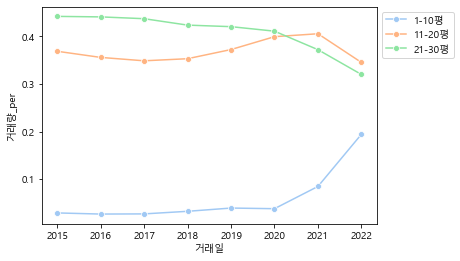

In [240]:
fig = sns.lineplot(data=tmp6_1, x='거래일', y='거래량_per', hue='평 범주', marker='o')
fig.legend(loc='upper left', labels=['1-10평', '11-20평', '21-30평'], bbox_to_anchor=(1, 1))
plt.show(fig)

In [239]:
tmp6_1.loc[(tmp6_1['거래일'] == 2015) | (tmp6_1['거래일'] == 2022)]

,index,거래일,평 범주,거래량,거래량_per
0,0,2015,1-10,3493,0.029183
1,1,2015,11-20,44125,0.368658
2,2,2015,21-30,52892,0.441905
49,49,2022,1-10,4341,0.194454
50,50,2022,11-20,7705,0.345144
51,51,2022,21-30,7141,0.319880
